<font color=black size=5>CV 109</font>

<font color=black size=5>Information: Qingtan Shen (1130945)</font>

<font color=black size=5>Import Packages</font>

In [298]:
import numpy as np
import cv2
import os
import time
import matplotlib.pyplot as plt

<font color=black size=5>Upload Files</font>

In [299]:
# get filenames
# you should change the location of these images, and the codes below will get the filename list automatically
direct = '/Users/apple/Desktop/COMP90086/Dataset'
file_name = os.listdir(direct)
image_name = []
for one in file_name:
    if len(one.split('disparity')) > 1:
        image_name.append(one.split('disparity')[0])

left_images = []
right_images = []
disparity_images = []
for i in image_name:
    left = i + 'left.jpg'
    left_images.append(left)
    right = i + 'right.jpg'
    right_images.append(right)
    disparity = i + 'disparity.png'
    disparity_images.append(disparity)

<font color=black size=5>the Baseline Algorithm Function</font>

In [300]:
# the baseline algorithm function
def baseline_model_NCC(left_name, right_name, window_size):
    r_array = []

    remain_row = len(left_name) - int(len(left_name) / window_size) * window_size
    remain_col = len(left_name[0]) - int(len(left_name[0]) / window_size) * window_size
    row_length = int(len(left_name) / window_size)
    col_length = int(len(left_name[0]) / window_size)

    for i in range(row_length):
        r_line_array = []
        for j in range(col_length):
            r_list = []
            r_list.append([right[i][j], right[i][j + 1], right[i][j + 2], right[i][j + 3],
                           right[i + 1][j], right[i + 1][j + 1], right[i + 1][j + 2], right[i + 1][j + 3],
                           right[i + 2][j], right[i + 2][j + 1], right[i + 2][j + 2], right[i + 2][j + 3],
                           right[i + 3][j], right[i + 3][j + 1], right[i + 3][j + 2], right[i + 3][j + 3]])
            r_line_array.append(r_list[0])
        r_array.append(r_line_array)
    r_array = np.array(r_array)

    last_position = []
    for i in range(row_length):
        x_position = []
        for j in range(col_length):
            l_list = []
            l_list.append([left[i][j], left[i][j + 1], left[i][j + 2], left[i][j + 3],
                           left[i + 1][j], left[i + 1][j + 1], left[i + 1][j + 2], left[i + 1][j + 3],
                           left[i + 2][j], left[i + 2][j + 1], left[i + 2][j + 2], left[i + 2][j + 3],
                           left[i + 3][j], left[i + 3][j + 1], left[i + 3][j + 2], left[i + 3][j + 3]])
            l_array = np.array(l_list[0])
            # k is the group of 16 elements 
            # choose 16 pixels from different positions in one window, instead of using all pixels in the window, 
            # which shows a better and efficient result
            max_value = -1000
            posiX = -1
            for k in range(len(r_array[i][0])):
                if (np.sqrt(sum(l_array ** 2)) * np.sqrt(sum(r_array[i][k] ** 2))) == 0:
                    value = 0
                else:
                    value = sum(l_array * r_array[i][k]) / (np.sqrt(sum(l_array ** 2)) * np.sqrt(sum(r_array[i][k] ** 2)))
                if value > max_value:
                    max_value = value
                    posiX = k
            lo = 1
            while lo <= window_size:
                x_position.append(posiX)
                lo += 1
        if remain_col > 0:
            p = remain_col
            while p > 0:
                x_position.append(0)
                p -= 1
                
        last_position.append(x_position)

    position_array = np.array(last_position)
    final_distance = []
    left_position = []
    for i in range(col_length):
        lo1 = 1
        while lo1 <= window_size:
            left_position.append(i)
            lo1 += 1
    
    if remain_col > 0:
        p1 = remain_col
        while p1 > 0:
            left_position.append(0)
            p1 -= 1
            
    for i in range(row_length):
        loc = 1
        while loc <= window_size:
            final_distance.append(np.abs(position_array[i] - left_position) * window_size)
            loc += 1
            
    if remain_row > 0:
        q1 = remain_row
        add_row = []
        while q1 > 0:
            for i in range(left_name[0]):
                add_row.append(0)
            final_distance.append(np.array(add_row))
            q1 -= 1   
    
    return final_distance

<font color=black size=5>Create Functions For the New Algorithm</font>

In [301]:
# the new algorithm (functions)

# get peak pairs function
def get_pair_nodes(l_list, r_list):
    already = []
    pair_list = []
    peak_distance = []
    for l_node in l_list:
        lr_distance = 1000
        find_one = False
        for r_node in r_list:
            if r_node < l_node and l_node - r_node < 80 and r_node not in already:
                find_one = True
                if l_node - r_node < lr_distance:
                    lr_distance = l_node - r_node
                    best_fit = r_node
        # if we find a good pair of left node
        if find_one == True:
            pair_list.append((l_node, best_fit))
            already.append(best_fit)
            peak_distance.append(lr_distance)

    return (pair_list, peak_distance)

# get range pairs function
def get_ranges(l_gradient, r_gradient, pair_nodes):
    # set four restrictions and trace them in the loop
    ldl_res = 0
    ldr_res = 0
    if len(pair_nodes) >= 2:
        rdl_res = pair_nodes[1][0]
        rdr_res = pair_nodes[1][1]
    else:
        rdl_res = len(l_gradient)
        rdr_res = len(l_gradient)
    l_range = []
    r_range = []
    for i in range(len(pair_nodes)):
        # left check direction
        xlp = pair_nodes[i][0]
        ylp = pair_nodes[i][1]
        lldcp = xlp - 1
        rldcp = ylp - 1
        lrdcp = xlp + 1
        rrdcp = ylp + 1
        xlnode = xlp
        xrnode = xlp
        ylnode = ylp
        yrnode = ylp

        # consider left direction
        while (abs(l_gradient[lldcp] - r_gradient[rldcp]) <= 15 and lldcp > ldl_res and rldcp > ldr_res):
            xlnode = lldcp
            ylnode = rldcp
            lldcp -= 1
            rldcp -= 1

        # consider right direction
        while ((lrdcp < len(l_gradient)) and (rrdcp < len(l_gradient)) and abs(
                l_gradient[lrdcp] - r_gradient[rrdcp]) <= 15 and lrdcp < rdl_res and rrdcp < rdr_res):
            xrnode = lrdcp
            yrnode = rrdcp
            lrdcp += 1
            rrdcp += 1
        l_range.append((xlnode, xrnode))
        r_range.append((ylnode, yrnode))
        ldl_res = lrdcp
        ldr_res = rrdcp

        if i + 2 < len(pair_nodes):
            rdl_res = pair_nodes[i + 2][0]
            rdr_res = pair_nodes[i + 2][1]
        else:
            rdl_res = len(l_gradient)
            rdr_res = len(r_gradient)

    return (l_range, r_range)

# operation after knowing peak pairs and range pairs
def final_operation(middle_step, peak_distance, long_size):
    final_range = []
    final_distance = []
    l_range = middle_step[0]
    r_range = middle_step[1]

    # consider start of left range:
    if l_range != []:
        if l_range[0][0] > 0:
            final_range.append((0, l_range[0][0] - 1))
            final_distance.append(l_range[0][0] - r_range[0][0])
        for i in range(len(l_range)):
            final_range.append((l_range[i][0], l_range[i][1]))
            final_distance.append(peak_distance[i])
            if i + 1 < len(l_range):
                if l_range[i + 1][0] - l_range[i][1] > 1:
                    final_range.append((l_range[i][1] + 1, l_range[i + 1][0] - 1))
                    final_distance.append(round(((l_range[i][1] - r_range[i][1]) + 
                                                 (l_range[i + 1][0] - r_range[i + 1][0])) / 2))
            else:
                if l_range[i][1] < long_size:
                    final_range.append((l_range[i][1], long_size))
                    final_distance.append(l_range[i][1] - r_range[i][1])
    else:
        final_range.append((0, long_size))
        final_distance.append(0)

    return (final_range, final_distance)

# do derivative calculation and combine the three functions above in this single function, as the main function of our new algorithm
def new_approach(gau_left, gau_right, row_num, col_length):
    # after: delete the first node to be the after list
    l_af = np.delete(gau_left[row_num], 0)
    l_af = l_af.astype(int)
    # before: delete the last node to be the first list
    l_be = np.delete(gau_left[row_num], len(gau_left[0]) - 1)
    l_be = l_be.astype(int)
    l_gradience = l_af - l_be

    r_af = np.delete(gau_right[row_num], 0)
    r_af = r_af.astype(int)
    # before: delete the last node to be the first list
    r_be = np.delete(gau_right[row_num], len(gau_right[0]) - 1)
    r_be = r_be.astype(int)
    r_gradience = r_af - r_be

    l_higher = []
    i = 0
    while i < len(l_gradience):
        if l_gradience[i] >= 3:
            l_higher.append(i)
            i += 10
        else:
            i += 1

    r_higher = []
    z = 0
    while z < len(r_gradience):
        if r_gradience[z] >= 3:
            r_higher.append(z)
            z += 10
        else:
            z += 1

    pair_nodes = get_pair_nodes(l_higher, r_higher)[0]
    peak_distance = get_pair_nodes(l_higher, r_higher)[1]
    pair_ranges = get_ranges(l_gradience, r_gradience, pair_nodes)
    range_distance = final_operation(pair_ranges, peak_distance, col_length)

    # change the format of the result
    dis_result = []
    for j in range(len(range_distance[0])):
        num = range_distance[0][j][1] - range_distance[0][j][0] + 1
        dis_result += num * [range_distance[1][j]]
    if len(range_distance[0]) == 1:
        dis_result.append(0)

    return dis_result

# a small step when doing vertical smoothing
def get_mode(alist):
    dict_num = {}
    for i in range(len(alist)):
        if alist[i] not in dict_num.keys():
            dict_num[alist[i]] = 1
        else:
            dict_num[alist[i]] += 1
    max_v = 0
    best_value = -1

    key_list = []
    for z in dict_num:
        key_list.append(z)

    for j in key_list:
        if dict_num[j] > max_v:
            max_v = dict_num[j]
            best_value = j

    # two conditions: all values are not the same, or some values are the same
    if max_v == 1:
        best_value = alist[int((len(alist) - 1) / 2)]
    # second condition already calculated in the loop
    return best_value


# let the vertical smooth size is 5
# main function for vertical smoothing 
def vertical_smooth(image):
    oper_array = np.array(image).T
    new_list = []
    for i in oper_array:
        now_new_list = []
        # first one : consider 0,1,2,3,4
        now_new_list.append(i[0])
        now_new_list.append(i[1])
        least = 2
        # last one : consider 395,396,397,398,399
        last = len(image) - 3
        # initialize i
        j = least
        while j <= last:
            now_list = [i[j - 2], i[j - 1], i[j], i[j + 1], i[j + 2]]
            now_best = get_mode(now_list)
            now_new_list.append(now_best)
            j += 1
            
        now_new_list.append(i[len(image) - 2])
        now_new_list.append(i[len(image) - 1])
        new_list.append(now_new_list)

    return new_list

<font color=black size=5>the RMS Test Function</font>

In [302]:
# test RMS code
def get_square_error(getting_result, test_array):
    n = 0
    the_sum = 0
    for i in range(len(test_array)):
        for j in range(len(test_array[i])):
            if test_array[i][j] != 0:
                the_sum += (getting_result[i][j]-test_array[i][j])**2
                n += 1
    RMS = np.sqrt(the_sum / n)
    return RMS

<font color=black size=5>the Fraction Calculation Function</font>

In [303]:
# test fraction code
def get_fractions(getting_result, test_array):
    result = []
    total_use = 0
    dist_4 = 0
    dist_2 = 0
    dist_1 = 0
    dist_05 = 0
    dist_025 = 0
    for i in range(len(test_array)):
        for j in range(len(test_array[i])):
            if test_array[i][j] != 0:
                total_use += 1
                if np.abs(test_array[i][j]-getting_result[i][j]) <= 4:
                    dist_4 += 1
                if np.abs(test_array[i][j]-getting_result[i][j]) <= 2:
                    dist_2 += 1
                if np.abs(test_array[i][j]-getting_result[i][j]) <= 1:
                    dist_1 += 1
                if np.abs(test_array[i][j]-getting_result[i][j]) <= 0.5:
                    dist_05 += 1
                if np.abs(test_array[i][j]-getting_result[i][j]) <= 0.25:
                    dist_025 += 1
    result.append(total_use)
    result.append(dist_4/total_use)
    result.append(dist_2/total_use)
    result.append(dist_1/total_use)
    result.append(dist_05/total_use)
    result.append(dist_025/total_use)
    
    return result

<font color=black size=5>Apply the New Algorithm to the Images</font>

In [304]:
# experiment part
# apply the new algorithm to the images
time_spend = []
final_array_list = []
for image_index in range(len(left_images)):
    left = cv2.imread(os.path.join(direct, left_images[image_index]), cv2.IMREAD_GRAYSCALE)
    right = cv2.imread(os.path.join(direct, right_images[image_index]), cv2.IMREAD_GRAYSCALE)

    start = time.time()
    # gaussian method
    gau_kernel = cv2.getGaussianKernel(7, -1)
    gau_kern2d = np.outer(gau_kernel, gau_kernel)
    gau_kern2d = gau_kern2d / gau_kern2d.sum()
    gau_left = cv2.filter2D(left, -1, gau_kern2d)
    gau_right = cv2.filter2D(right, -1, gau_kern2d)
    len_col = len(left[0])

    result_image = []
    for row_index in range(len(gau_left)):
        dis = new_approach(gau_left, gau_right, row_index, len_col)
        # delete the first and last element in the list dis_result, to get the same dimension as our original image
        result_image.append(dis[1:len(dis) - 1])

    # vertical smooth application
    final_list = vertical_smooth(result_image)
    final_array = np.array(final_list).T
    
    end = time.time()
    total_time = end - start
    
    final_array_list.append(final_array)
    time_spend.append(total_time)

<font color=black size=5>Test Period for the New Algorithm Results</font>

In [305]:
# test period for the new algorithm results
SR_mean = []
frac_values = []
for image_index in range(len(disparity_images)):
    test_array = cv2.imread(os.path.join(direct, disparity_images[image_index]), cv2.IMREAD_GRAYSCALE)
    m1 = get_square_error(final_array_list[image_index], test_array)
    m2 = get_fractions(final_array_list[image_index], test_array)
    SR_mean.append(m1)
    frac_values.append(m2)

<font color=black size=5>RMS Value (New Algorithm)</font>

In [306]:
SR_mean

[14.616199777574728,
 9.188703542975087,
 20.340285946019442,
 12.364887589050632,
 15.438134818192164,
 23.498191506332088,
 21.386510172302444,
 25.774188064448836,
 28.37756878472,
 20.95014863216363,
 23.023883503596245,
 34.32797596618543,
 20.62274086044277,
 29.679944529385516,
 18.597685065198327,
 17.374144155928143,
 28.08354449046399,
 15.305453655811439,
 20.603690638973948,
 18.63913582228933,
 24.97462698583409,
 25.9543081565274,
 21.819109106131876,
 25.114244520850647,
 6.853591596100471]

<font color=black size=5>Fraction Value (New Algorithm)</font>

In [307]:
frac_values

[[90029,
  0.6586433260393874,
  0.5882437881127193,
  0.459029868153595,
  0.18508480600695332,
  0.18508480600695332],
 [86686,
  0.7634681494128233,
  0.6830976166855086,
  0.4823846987979605,
  0.16201001315091249,
  0.16201001315091249],
 [90095,
  0.4902380820245297,
  0.4511904101226483,
  0.3531716521449581,
  0.1442921360785837,
  0.1442921360785837],
 [67829,
  0.7241445399460408,
  0.6059797431776969,
  0.38244703592858514,
  0.12409146530245176,
  0.12409146530245176],
 [80424,
  0.6271635332736497,
  0.543855068138864,
  0.4123022978215458,
  0.1663185118869989,
  0.1663185118869989],
 [89719,
  0.5223308329339382,
  0.3851469588381502,
  0.260346191999465,
  0.09388200938485716,
  0.09388200938485716],
 [74098,
  0.5143323706442819,
  0.4427784825501363,
  0.3706847688196713,
  0.15656293017355394,
  0.15656293017355394],
 [95184,
  0.4979723482938309,
  0.43430618591359893,
  0.3340057152462599,
  0.13751260716086738,
  0.13751260716086738],
 [98544,
  0.4327711479136223

<font color=black size=5>Time Spend in Seconds (New Algorithm)</font>

In [308]:
time_spend

[3.6305959224700928,
 1.8566169738769531,
 1.7099907398223877,
 1.6637818813323975,
 1.6830182075500488,
 1.7470359802246094,
 1.6531503200531006,
 1.6452341079711914,
 1.617426872253418,
 1.6474571228027344,
 1.5728330612182617,
 1.631828784942627,
 1.6472647190093994,
 1.6029791831970215,
 1.6409978866577148,
 1.664302110671997,
 1.615062952041626,
 1.6652131080627441,
 1.6493680477142334,
 1.6686241626739502,
 1.6326463222503662,
 1.615049123764038,
 1.6532797813415527,
 1.699186086654663,
 1.6669130325317383]

<font color=black size=5>Apply the Baseline Algorithm to the Images</font>

In [309]:
# apply the baseline algorithm to the images
old_time_spend = []
old_final_array_list = []
for image_index in range(len(left_images)):
    
    left = cv2.imread(os.path.join(direct, left_images[image_index]), cv2.IMREAD_GRAYSCALE)
    right = cv2.imread(os.path.join(direct, right_images[image_index]), cv2.IMREAD_GRAYSCALE)

    start = time.time()
    # gaussian method
    gau_kernel = cv2.getGaussianKernel(7, -1)
    gau_kern2d = np.outer(gau_kernel, gau_kernel)
    gau_kern2d = gau_kern2d / gau_kern2d.sum()
    gau_left = cv2.filter2D(left, -1, gau_kern2d)
    gau_right = cv2.filter2D(right, -1, gau_kern2d)
    
    # the window size we choose is 8
    distance_array = baseline_model_NCC(gau_left, gau_right, 8)
    
    end = time.time()
    total_time = end - start
    
    old_final_array_list.append(distance_array)
    old_time_spend.append(total_time)

<font color=black size=5>Test Period for the Baseline Algorithm Results</font>

In [310]:
# test period for the baseline algorithm results
old_SR_mean = []
old_frac_values = []
for image_index in range(len(disparity_images)):
    test_array = cv2.imread(os.path.join(direct, disparity_images[image_index]), cv2.IMREAD_GRAYSCALE)
    m1 = get_square_error(old_final_array_list[image_index], test_array)
    m2 = get_fractions(old_final_array_list[image_index], test_array)
    old_SR_mean.append(m1)
    old_frac_values.append(m2)

<font color=black size=5>RMS Value (Baseline Algorithm)</font>

In [311]:
old_SR_mean

[414.6962470780688,
 414.673850975978,
 478.15249343856766,
 349.05794671004895,
 382.3557838930577,
 437.84352226371556,
 372.348407808083,
 419.9243791809937,
 437.92210440245356,
 405.75859300121886,
 419.3145817763114,
 436.69129843161824,
 383.7042488930465,
 433.2203111546494,
 381.47676176872847,
 436.528934968104,
 431.60580526483716,
 418.040304890572,
 437.7513464196363,
 454.9491086545688,
 412.3060704334207,
 440.51195244961644,
 433.40038512741074,
 432.7093898464225,
 436.6558743900305]

<font color=black size=5>Fraction Value (Baseline Algorithm)</font>

In [312]:
old_frac_values

[[90029,
  0.011773983938508703,
  0.008308433949060858,
  0.006098035077586111,
  0.0004665163447333637,
  0.0004665163447333637],
 [86686,
  0.023660106591606486,
  0.016288674065016266,
  0.01252797452875897,
  0.006148628382899199,
  0.006148628382899199],
 [90095,
  0.013408069260225317,
  0.008368943892557856,
  0.0056717908873966365,
  0.0029191409068205785,
  0.0029191409068205785],
 [67829,
  0.02643412109864512,
  0.011735393415795603,
  0.004304943313332056,
  0.0010320069586754927,
  0.0010320069586754927],
 [80424,
  0.022406246891475183,
  0.013366656719387247,
  0.007124738883915249,
  0.0030712225206406046,
  0.0030712225206406046],
 [89719,
  0.012583733657307817,
  0.008560059742083617,
  0.005829311517069963,
  0.002151160846643409,
  0.002151160846643409],
 [74098,
  0.02381980620259656,
  0.012766876298955437,
  0.009446948635590703,
  0.0018084158816702206,
  0.0018084158816702206],
 [95184,
  0.012249957976130443,
  0.006723819129265423,
  0.0035194990754748696,


<font color=black size=5>Time Spend in Seconds (Baseline Algorithm)</font>

In [313]:
old_time_spend

[3.7975728511810303,
 3.8121321201324463,
 3.804723024368286,
 3.7135400772094727,
 3.7830650806427,
 3.7686727046966553,
 3.8267462253570557,
 3.8603668212890625,
 3.8506228923797607,
 3.780919075012207,
 3.3928539752960205,
 3.789614200592041,
 3.773474931716919,
 3.783841848373413,
 3.779249906539917,
 3.775790214538574,
 3.7839837074279785,
 3.817819118499756,
 3.8017048835754395,
 3.7709031105041504,
 3.696249008178711,
 3.7763593196868896,
 3.7734241485595703,
 3.7833080291748047,
 3.769213914871216]

<font color=black size=5>RMS Plot (Baseline Algorithm)</font>

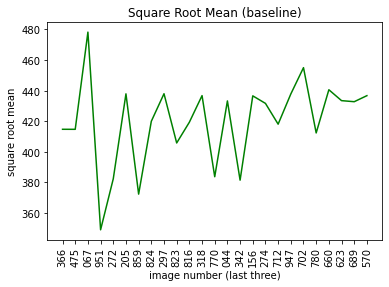

In [314]:
# data visualization (RMS for the baseline algorithm result)
plot_label = []
for one_name in image_name:
    plot_label.append(one_name.split('-')[11])

plt.plot(plot_label, old_SR_mean, color='green', label='baseline')

plt.title('Square Root Mean (baseline)')
plt.xlabel('image number (last three)')
plt.ylabel('square root mean')
plt.xticks(rotation=90)

plt.show()

<font color=black size=5>RMS Plot (New Algorithm)</font>

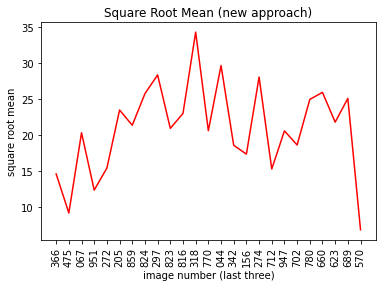

In [315]:
# data visualization (RMS for the new algorithm result)
plt.plot(plot_label, SR_mean, color='red', label='new approach')

plt.title('Square Root Mean (new approach)')
plt.xlabel('image number (last three)')
plt.ylabel('square root mean')
plt.xticks(rotation=90)

plt.show()

<font color=black size=5>Fraction Plot (Baseline Algorithm)</font>

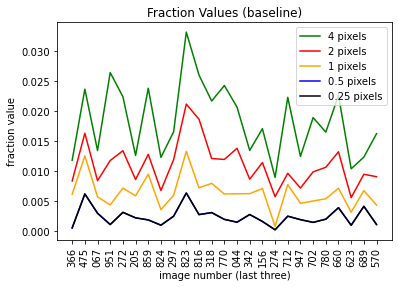

In [316]:
# data visualization (fraction values for the baseline algorithm result)
ol4, ol2, ol1, ol05, ol025 = [], [], [], [], []
for i in old_frac_values:
    ol4.append(i[1])
    ol2.append(i[2])
    ol1.append(i[3])
    ol05.append(i[4])
    ol025.append(i[5])

plt.plot(plot_label, ol4, color='green', label='4 pixels')
plt.plot(plot_label, ol2, color='red', label='2 pixels')
plt.plot(plot_label, ol1, color='orange', label='1 pixels')
plt.plot(plot_label, ol05, color='blue', label='0.5 pixels')
plt.plot(plot_label, ol025, color='black', label='0.25 pixels')

plt.title('Fraction Values (baseline)')
plt.xlabel('image number (last three)')
plt.ylabel('fraction value')
plt.xticks(rotation=90)
plt.legend()

plt.show()

<font color=black size=5>Fraction Plot (New Algorithm)</font>

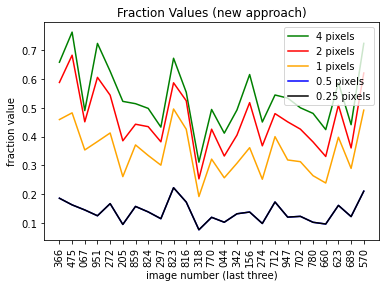

In [317]:
# data visualization (fraction values for the new algorithm result)
nl4, nl2, nl1, nl05, nl025 = [], [], [], [], []
for i in frac_values:
    nl4.append(i[1])
    nl2.append(i[2])
    nl1.append(i[3])
    nl05.append(i[4])
    nl025.append(i[5])

plt.plot(plot_label, nl4, color='green', label='4 pixels')
plt.plot(plot_label, nl2, color='red', label='2 pixels')
plt.plot(plot_label, nl1, color='orange', label='1 pixels')
plt.plot(plot_label, nl05, color='blue', label='0.5 pixels')
plt.plot(plot_label, nl025, color='black', label='0.25 pixels')

plt.title('Fraction Values (new approach)')
plt.xlabel('image number (last three)')
plt.ylabel('fraction value')
plt.xticks(rotation=90)
plt.legend()

plt.show()

<font color=black size=5>Running Time (Two Algorithms Comparison)</font>

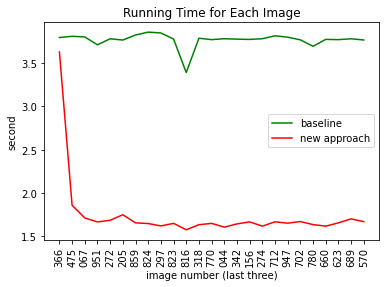

In [318]:
# data visualization (running time comparison for the baseline algorithm and the new algorithm)
plt.plot(plot_label, old_time_spend, color='green', label='baseline')
plt.plot(plot_label, time_spend, color='red', label='new approach')

plt.title('Running Time for Each Image')
plt.xlabel('image number (last three)')
plt.ylabel('second')
plt.xticks(rotation=90)
plt.legend()

plt.show()